## Diabetes Prediction with XGboost 

In [6]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [8]:
df = pd.read_csv("diabetes_dataset.csv")

In [9]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [10]:
df.dtypes 

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [12]:
df.shape

(100000, 9)

In [13]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [14]:
print(df.dtypes.unique())

[dtype('O') dtype('float64') dtype('int64')]


In [15]:
duplicates = df.duplicated()

In [16]:
duplicates.sum()

3854

In [17]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

# Data Preprocessing

In [18]:
df['smoking_history'] = df['smoking_history'].replace(['former', 'ever','not current'], 'Non_active_Smoker')


In [19]:
df['smoking_history'] = df['smoking_history'].replace(['current'], 'Active_Smoker')


In [20]:
df['smoking_history'] = df['smoking_history'].replace(['never'], 'Non_Smoker')


In [22]:
df['smoking_history']

0               Non_Smoker
1                  No Info
2               Non_Smoker
3            Active_Smoker
4            Active_Smoker
               ...        
99995              No Info
99996              No Info
99997    Non_active_Smoker
99998           Non_Smoker
99999        Active_Smoker
Name: smoking_history, Length: 100000, dtype: object

In [21]:
CatCols=['gender','smoking_history','diabetes']
NumCols=list(set(df.columns)-set(CatCols))

In [23]:
#Fix type of columns
df[CatCols] = df[CatCols].apply(lambda x: x.astype('category'))
df[NumCols] = df[NumCols].apply(lambda x: x.astype('float64'))

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   gender               100000 non-null  category
 1   age                  100000 non-null  float64 
 2   hypertension         100000 non-null  float64 
 3   heart_disease        100000 non-null  float64 
 4   smoking_history      100000 non-null  category
 5   bmi                  100000 non-null  float64 
 6   HbA1c_level          100000 non-null  float64 
 7   blood_glucose_level  100000 non-null  float64 
 8   diabetes             100000 non-null  category
dtypes: category(3), float64(6)
memory usage: 4.9 MB


## Exploratory Data Analysis

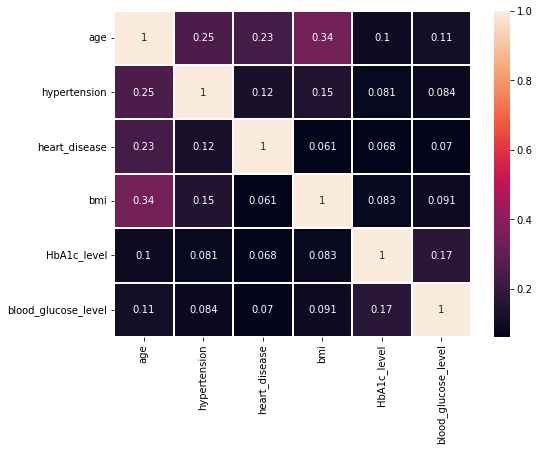

In [25]:
#checking correlation between features
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, linewidths=2)
plt.show()

Column : gender


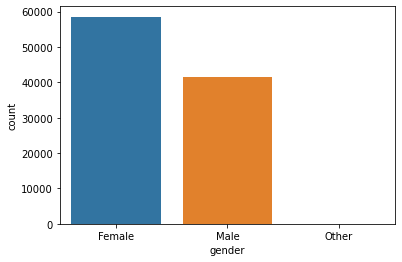

['Female', 'Male', 'Other']
Categories (3, object): ['Female', 'Male', 'Other']

Percentage for each Catagory (%):
Female    58.6
Male      41.4
Other      0.0
Name: gender, dtype: float64


Column : smoking_history


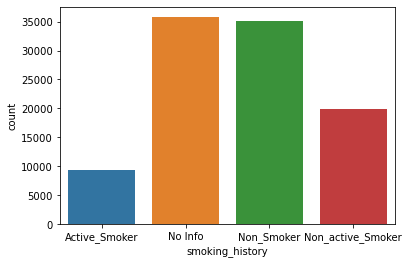

['Non_Smoker', 'No Info', 'Active_Smoker', 'Non_active_Smoker']
Categories (4, object): ['Active_Smoker', 'No Info', 'Non_Smoker', 'Non_active_Smoker']

Percentage for each Catagory (%):
No Info              35.8
Non_Smoker           35.1
Non_active_Smoker    19.8
Active_Smoker         9.3
Name: smoking_history, dtype: float64


Column : diabetes


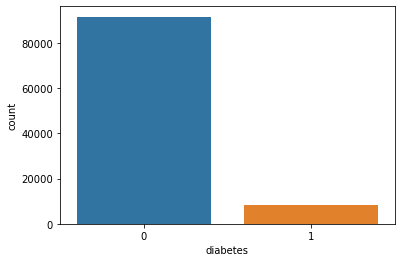

[0, 1]
Categories (2, int64): [0, 1]

Percentage for each Catagory (%):
0    91.5
1     8.5
Name: diabetes, dtype: float64




In [26]:
#Explore the categorical column
for col in CatCols:
    print('Column : {}'.format(col))
    sns.countplot(x=col, data=df)
    plt.show()
    print(df[col].unique())
    print('\nPercentage for each Catagory (%):')
    print(round(df[col].value_counts(normalize = True),3)*100)
    print('\n')

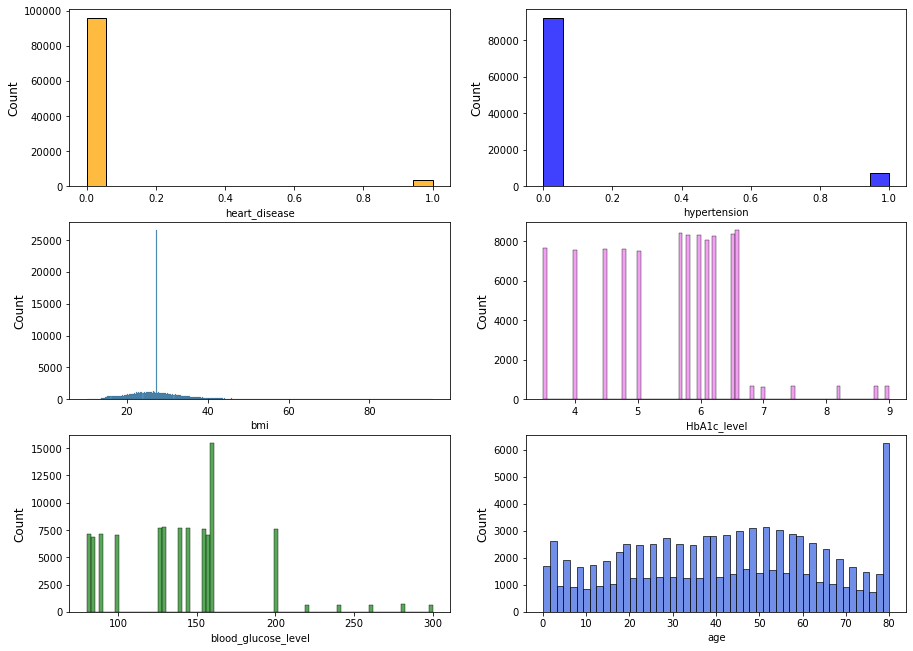

In [27]:
#Explore the numberical/float column
plt.figure(figsize=(15,15))

plt.subplot(4,2,1)
sns.histplot(df['heart_disease'], color='orange')
plt.ylabel('Count', fontsize=12)

plt.subplot(4,2,2)
sns.histplot(df['hypertension'], color='blue')
plt.ylabel('Count', fontsize=12)

plt.subplot(4,2,3)
sns.histplot(df['bmi'])
plt.ylabel('Count', fontsize=12)

plt.subplot(4,2,4)
sns.histplot(df['HbA1c_level'], color='violet')
plt.ylabel('Count', fontsize=12)

plt.subplot(4,2,5)
sns.histplot(df['blood_glucose_level'], color='forestgreen')
plt.ylabel('Count', fontsize=12)

plt.subplot(4,2,6)
sns.histplot(df['age'], color='royalblue')
plt.ylabel('Count', fontsize=12)
plt.show()

In [28]:
 df['diabetes'].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

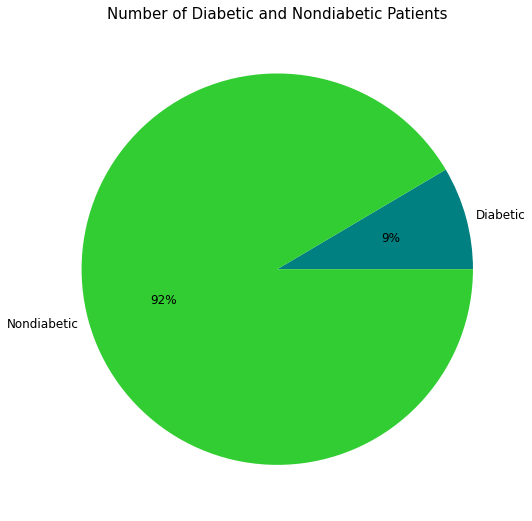

In [29]:
plt.figure(figsize=(9,9))
plt.pie(x=[8500,91500], labels=[ 'Diabetic', 'Nondiabetic'], autopct='%1.0f%%',pctdistance=0.6,labeldistance=1.05,textprops={'fontsize':12},colors=['teal','limegreen'])
plt.title('Number of Diabetic and Nondiabetic Patients',loc='center', fontsize=15)
plt.show()

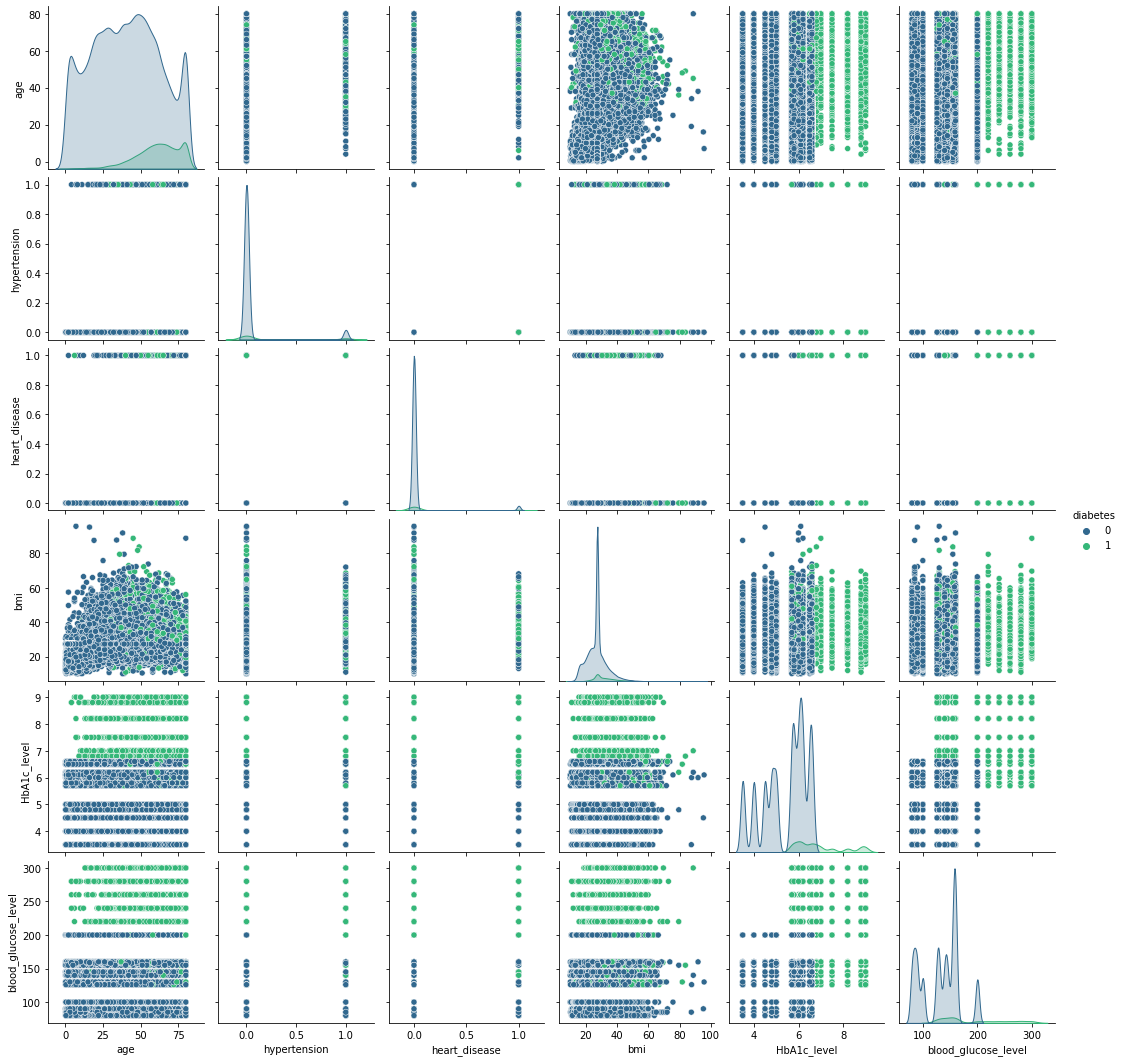

In [30]:
sns.pairplot(df,hue='diabetes',palette='viridis')
plt.show()


# Feature Scaling

In [37]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']

In [38]:
X.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0.0,1.0,Non_Smoker,25.19,6.6,140.0
1,Female,54.0,0.0,0.0,No Info,27.32,6.6,80.0
2,Male,28.0,0.0,0.0,Non_Smoker,27.32,5.7,158.0
3,Female,36.0,0.0,0.0,Active_Smoker,23.45,5.0,155.0
4,Male,76.0,1.0,1.0,Active_Smoker,20.14,4.8,155.0


In [39]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: diabetes, dtype: category
Categories (2, int64): [0, 1]

In [40]:
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   age                                100000 non-null  float64
 1   hypertension                       100000 non-null  float64
 2   heart_disease                      100000 non-null  float64
 3   bmi                                100000 non-null  float64
 4   HbA1c_level                        100000 non-null  float64
 5   blood_glucose_level                100000 non-null  float64
 6   gender_Male                        100000 non-null  uint8  
 7   gender_Other                       100000 non-null  uint8  
 8   smoking_history_No Info            100000 non-null  uint8  
 9   smoking_history_Non_Smoker         100000 non-null  uint8  
 10  smoking_history_Non_active_Smoker  100000 non-null  uint8  
dtypes: float64(6), uint8(5)
memory usage: 5.

In [35]:
xgbc = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy , y, test_size=0.25, 
                                                    random_state=42, stratify=y)

# PCA on Numerical Columns only


In [44]:
X_train_sc = StandardScaler().fit_transform(X_train)
X_test_sc = StandardScaler().fit_transform(X_test)

In [45]:
from sklearn.preprocessing import MinMaxScaler
#MinMaxScaler 
X_train_msc = MinMaxScaler().fit_transform(X_train)
X_test_msc = MinMaxScaler().fit_transform(X_test)

In [46]:
from sklearn.preprocessing import PowerTransformer
#PowerTransformer
power = PowerTransformer()
X_train_power = power.fit_transform(X_train)
X_test_power = power.fit_transform(X_test)

In [47]:
X_train_sc=pd.DataFrame(X_train_sc, columns=X_train.columns)
X_train_sc.index=X_train.index
X_test_sc=pd.DataFrame(X_test_sc, columns=X_test.columns)
X_test_sc.index=X_test.index

In [48]:
train_PCA=X_train_sc[NumCols]
test_PCA=X_test_sc[NumCols]

In [49]:
train_PCA


,blood_glucose_level,hypertension,age,heart_disease,bmi,HbA1c_level
98078,0.415531,-0.284884,-1.282656,-0.203379,0.000149,-1.428266
84833,-1.429262,-0.284884,-1.820556,-0.203379,-1.824601,1.001233
50495,1.522406,-0.284884,-1.637706,-0.203379,-1.433153,0.534021
9896,0.169558,-0.284884,1.690884,-0.203379,0.445798,0.534021
40910,-1.183290,-0.284884,-1.193894,-0.203379,-2.213038,1.001233
...,...,...,...,...,...,...
17083,-0.199400,-0.284884,-0.128745,-0.203379,0.746912,-0.680728
27250,0.489322,-0.284884,0.048780,-0.203379,0.000149,0.627464
33409,0.415531,3.510198,0.448211,-0.203379,0.000149,0.253694
91639,0.415531,-0.284884,-1.637706,-0.203379,-1.752333,0.627464


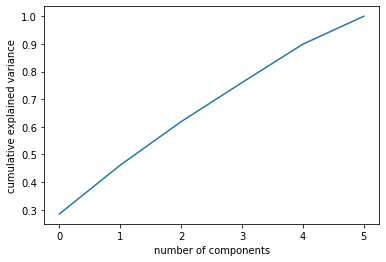

In [50]:
from sklearn.decomposition import PCA
pca = PCA().fit(train_PCA)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [52]:
pca = PCA(5).fit(train_PCA)
PCA_train = pca.transform(train_PCA)
PCA_test = pca.transform(test_PCA)

In [53]:
PCA_train=pd.DataFrame(X_train_sc, columns=X_train.columns)
X_train_sc.index=X_train.index
X_test_sc=pd.DataFrame(X_test_sc, columns=X_test.columns)
X_test_sc.index=X_test.index

# XGBoost Classifier Machine Learning

In [54]:
xgbc = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)

In [55]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [56]:
prediction_xgbc=xgbc.predict(X_test)

In [57]:
print(confusion_matrix(y_test,prediction_xgbc))
print('\n')
print(classification_report(y_test,prediction_xgbc))
print('\n')
print('Accuracy Score: ',round(accuracy_score(y_test,prediction_xgbc), ndigits=2))

[[22822    53]
 [  641  1484]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.99     22875
           1       0.97      0.70      0.81      2125

    accuracy                           0.97     25000
   macro avg       0.97      0.85      0.90     25000
weighted avg       0.97      0.97      0.97     25000



Accuracy Score:  0.97


We can see that the XGBoost Classifier has 97% accuracy in predicting the result of diabetes.